<a href="https://colab.research.google.com/github/jecampagne/cours_mallat_cdf/blob/main/randomwalk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import jax
import jax.numpy as jnp
from jax import random
from jax import grad, jit, vmap, value_and_grad
from jax.example_libraries import optimizers

from jax.config import config
config.update("jax_enable_x64", True)

# Numpy 
import numpy as np

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
mpl.rcParams['font.size'] = 18


from functools import partial


In [19]:
def f(carry,x):
  yold, keyold = carry
  _, key = jax.random.split(keyold)
  y = yold + 2.*jax.random.bernoulli(key)-1.
  return (y,key),y
  _, res = jax.lax.scan(f,(0., jax.random.PRNGKey(1)),jnp.arange(100))

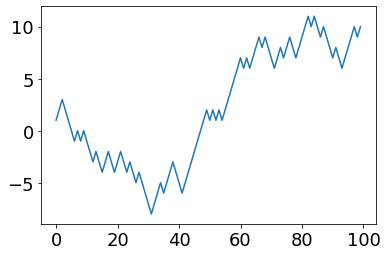

In [18]:
plt.plot(res)

In [31]:
@jit
def update(rng_key, position):
  key, subkey = jax.random.split(rng_key)
  move_proposals = 2.*jax.random.bernoulli(key)-1. 
  proposal = position + move_proposals
  return proposal


@partial(jit, static_argnums=(1,))
def sampler(rng_key, n_samples, initial_position):

  def _update(i, state):
        key, positions = state
        _, key = jax.random.split(key)
        new_position = update(key, positions[i-1])
        positions=positions.at[i].set(new_position)
        return (key, positions)

  # all positions structure should be set before lax.fori_loop    
  all_positions = jnp.zeros((n_samples,initial_position.shape[0]))  # 1 chain for each vmap call
    
  initial_state = (rng_key,all_positions)
  rng_key, all_positions = jax.lax.fori_loop(1, n_samples, 
                                                 _update, 
                                                 initial_state)
  return all_positions 

In [33]:
n_chains = 5
n_dim = 1
n_samples = 1000

rng_key = jax.random.PRNGKey(42)

rng_keys = jax.random.split(rng_key, n_chains)
initial_position = jnp.zeros((n_dim, n_chains))

run_mc= vmap(sampler, in_axes=(0, None, 1), out_axes=0)

all_positions = run_mc(rng_keys, n_samples,  initial_position)

all_positions = all_positions.squeeze()




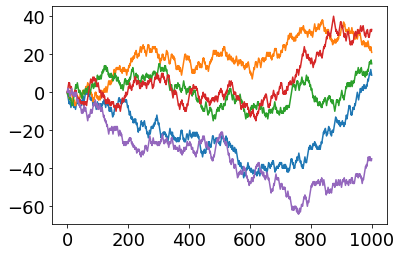

In [35]:
plt.plot(all_positions.T);